Attempting to load: SLU Opportunity Wise Data-1710158595043 - SLU Opportunity Wise Data-1710158595043.csv
Data loaded successfully.
Processing dates (this may take a moment)...
Duplicates removed: 0

--- Summary Statistics ---
Total Records: 8558
Unique Opportunities: 22
Top 5 Countries: {'United States': 3976, 'India': 2836, 'Nigeria': 760, 'Ghana': 275, 'Pakistan': 219}
Average Age: 25.731245618135077

--- Spikes Detected (Threshold: 94.92) ---
    Apply Date  count
365 2024-01-04    126
366 2024-01-05    160
369 2024-01-08    140
373 2024-01-12    101
385 2024-01-24    110
388 2024-01-27     95
390 2024-01-29    105
414 2024-02-22    107

Plot saved as 'daily_applications_plot.png'


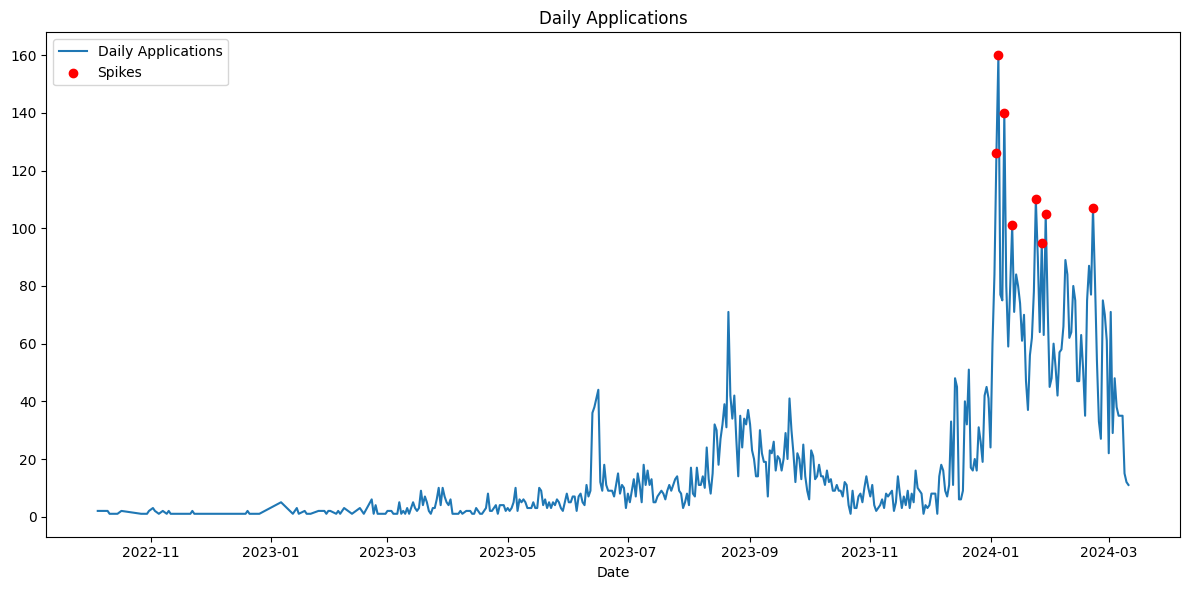

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dateutil import parser
import sys

# ==========================================
# IMPORTANT: UPDATE THIS FILENAME
# Make sure this matches the exact name of the file on your computer
# and that the file is in the same folder as this script.
file_name = "SLU Opportunity Wise Data-1710158595043 - SLU Opportunity Wise Data-1710158595043.csv"
# If it's a CSV, change extension to .csv
# ==========================================

# 1. Load the Data
print(f"Attempting to load: {file_name}")
try:
    # Try reading as Excel first, then CSV if that fails
    if file_name.endswith('.csv'):
        df = pd.read_csv(file_name)
    else:
        # Defaults to Excel if no extension or .xlsx
        df = pd.read_excel(file_name)
    print("Data loaded successfully.")

except FileNotFoundError:
    print(f"\nERROR: The file '{file_name}' was not found.")
    print("Please check that the file name in the script matches your file exactly.")
    sys.exit() # Stop execution here
except Exception as e:
    print(f"\nERROR: Could not load data. Reason: {e}")
    sys.exit() # Stop execution here

# 2. Fix Formatting Inconsistencies

# Helper function to parse dates robustly
def robust_date_parse(date_str):
    if pd.isna(date_str):
        return pd.NaT
    try:
        return parser.parse(str(date_str))
    except:
        return pd.NaT

date_cols = ['Learner SignUp DateTime', 'Opportunity End Date', 'Date of Birth',
             'Entry created at', 'Apply Date', 'Opportunity Start Date']

print("Processing dates (this may take a moment)...")
for col in date_cols:
    if col in df.columns:
        try:
            df[col] = pd.to_datetime(df[col], format='mixed', errors='coerce')
        except ValueError:
            df[col] = df[col].apply(robust_date_parse)

# Standardize Text Columns
text_cols = ['Gender', 'Country', 'Institution Name', 'Current/Intended Major', 'Status Description']
for col in text_cols:
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip().str.title()

# 3. Address Missing or Duplicate Entries
df.replace({'Nan': 'Unknown', 'None': 'Unknown'}, inplace=True)
initial_count = len(df)
df = df.drop_duplicates()
print(f"Duplicates removed: {initial_count - len(df)}")

# 4. Calculate Basic Summary Statistics
now = pd.Timestamp.now()
if 'Date of Birth' in df.columns:
    df['Age'] = (now - df['Date of Birth']).dt.days // 365
    avg_age = df['Age'].mean()
else:
    avg_age = "N/A"

summary_stats = {
    'Total Records': len(df),
    'Unique Opportunities': df['Opportunity Name'].nunique() if 'Opportunity Name' in df.columns else 0,
    'Top 5 Countries': df['Country'].value_counts().head(5).to_dict() if 'Country' in df.columns else {},
    'Average Age': avg_age
}

print("\n--- Summary Statistics ---")
for key, value in summary_stats.items():
    print(f"{key}: {value}")

# 5. Spot Unusual Spikes
if 'Apply Date' in df.columns:
    daily_applications = df.groupby(df['Apply Date'].dt.date).size().reset_index(name='count')
    daily_applications['Apply Date'] = pd.to_datetime(daily_applications['Apply Date'])

    mean_count = daily_applications['count'].mean()
    std_count = daily_applications['count'].std()
    threshold = mean_count + 3 * std_count
    spikes = daily_applications[daily_applications['count'] > threshold]

    print(f"\n--- Spikes Detected (Threshold: {threshold:.2f}) ---")
    print(spikes)

    # Visualization
    plt.figure(figsize=(12, 6))
    plt.plot(daily_applications['Apply Date'], daily_applications['count'], label='Daily Applications')
    plt.scatter(spikes['Apply Date'], spikes['count'], color='red', label='Spikes', zorder=5)
    plt.title('Daily Applications')
    plt.xlabel('Date')
    plt.legend()
    plt.tight_layout()
    plt.savefig('daily_applications_plot.png')
    print("\nPlot saved as 'daily_applications_plot.png'")